In [1]:

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-05-12 13:17:06.786960: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up the hyper parameters - as our data is combo of test and train we define validation split of 80/20

img_width = 64
img_height = 64
epochs = 5
batch_size = 32
validation_split = 0.2

In [3]:
# to try and get the visualisation working -
dataset_url = '/Users/will/Desktop/EuroSAT_RGB'
euro_sat_dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)


Found 27000 files belonging to 10 classes.


2023-05-12 13:19:15.619754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Using Data augmentation - to set up generators -

train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=40,
        validation_split=validation_split
    )
validation_datagen = ImageDataGenerator(
        rescale=1. / 255,
        validation_split=validation_split
        )

In [5]:
# Using flow_from_directory to use folder structure into creating the train_generator that contains the labels of
# images seperated into a training set and a testing set and categorical class labels

train_generator = train_datagen.flow_from_directory(
    directory='/Users/will/Desktop/EuroSAT_RGB',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset = "training",
    )

validation_generator = validation_datagen.flow_from_directory(
        '/Users/will/Desktop/EuroSAT_RGB',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset = "validation",
        )


Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


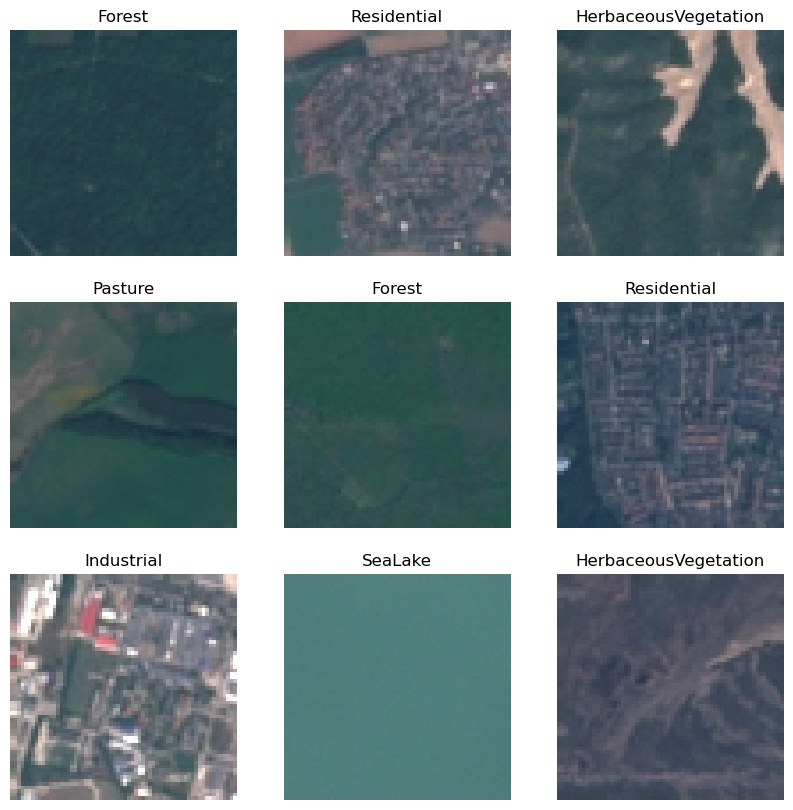

In [6]:
# Plot a sample of images from the train set together with their labels - this is pretty hacky

class_names = euro_sat_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in euro_sat_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


In [7]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

In [8]:
# Initialise a new model of type Sequential() called new_model. Then to it add a hidden layer with 256 neurons that
# outputs to a binary classifier.

# adds hidden layer before output to categorical classifier
num_classes = len(class_names)
new_model = models.Sequential()
new_model.add(base_model)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256, activation='relu'))
new_model.add(layers.Dense(num_classes, activation='softmax'))
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 15,241,802
Trainable params: 527,114
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
# compile model
learning_rate = 0.001
momentum = 0.9
optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
new_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



In [10]:
# fit new model
history = new_model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        shuffle=False
    )

Epoch 1/5
675/675 [==============================] - 393s 581ms/step - loss: 1.1362 - accuracy: 0.6032 - val_loss: 0.8691 - val_accuracy: 0.6489
Epoch 2/5
675/675 [==============================] - 390s 578ms/step - loss: 0.8043 - accuracy: 0.7221 - val_loss: 0.7362 - val_accuracy: 0.7624
Epoch 3/5
675/675 [==============================] - 396s 587ms/step - loss: 0.7113 - accuracy: 0.7551 - val_loss: 0.6691 - val_accuracy: 0.7663
Epoch 4/5
675/675 [==============================] - 395s 586ms/step - loss: 0.6493 - accuracy: 0.7772 - val_loss: 0.6833 - val_accuracy: 0.7726
Epoch 5/5
675/675 [==============================] - 397s 588ms/step - loss: 0.6126 - accuracy: 0.7871 - val_loss: 0.5789 - val_accuracy: 0.8091


169/169 [==============================] - 79s 463ms/step - loss: 0.5789 - accuracy: 0.8091


[0.5788810849189758, 0.8090741038322449]

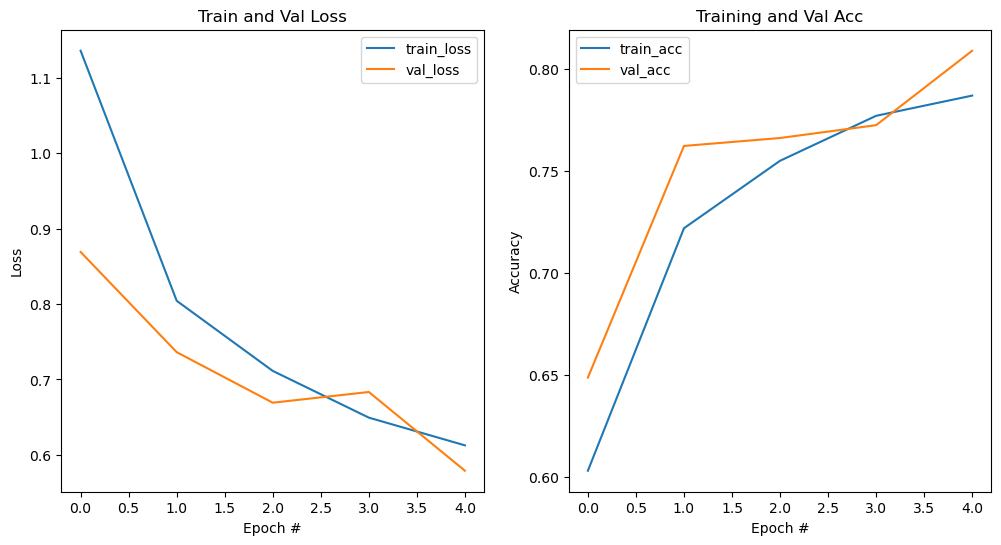

In [11]:
# Plot the loss and accuracy schedule of the model fitted and then calculate the final loss and accuracy figures of
# your model on the test set

fig, ax=plt.subplots(1,2,figsize=(12,6))
ax[0].set_title("Train and Val Loss")
ax[0].plot(history.history["loss"], label="train_loss")
ax[0].plot(history.history["val_loss"], label="val_loss")
ax[0].set_xlabel("Epoch #")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].set_title("Training and Val Acc")
ax[1].plot(history.history["accuracy"], label="train_acc")
ax[1].plot(history.history["val_accuracy"], label="val_acc")
ax[1].set_xlabel("Epoch #")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

new_model.evaluate(validation_generator)


1/1 [==============================] - 0s 32ms/step


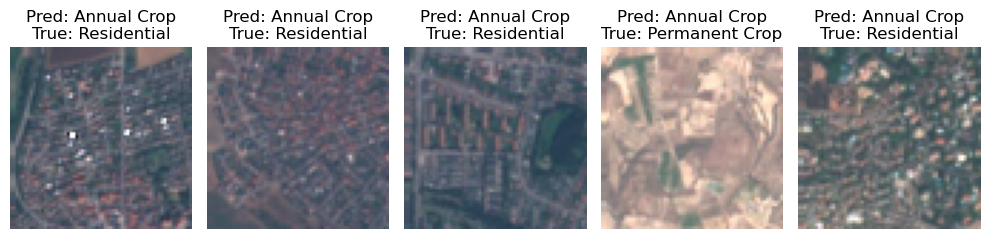

In [26]:
# Plot five or more images with its label (actual) class and predicted class. Do the labels correspond?

sample_training_images, labels = next(validation_generator)
label_names = ['Annual Crop','Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']

def load_image(image):
    img = image.astype('float32')
    img_tensor = np.expand_dims(img, axis=0)
    return img_tensor

images_arr = sample_training_images[:5]
labels = labels[:5]

fig, axes = plt.subplots(1, 5, figsize=(10,10))
axes = axes.flatten()
for img, ax, label in zip(images_arr, axes, labels):
    img_tensor= load_image(img)
    y_pred=new_model.predict(img_tensor)[0]
    pred_label = label_names[np.argmax(y_pred)]
    #print (y_pred)
    #print (np.round(y_pred))
    ax.imshow(img)
    ax.set_title(f'Pred: {label_names[int(label[0])]}\nTrue: {pred_label}')
    ax.axis('off')
plt.tight_layout()
plt.show()